In [6]:
import os
import json
import joblib

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

import preprocessing as prep
import machine_learning as ml
from pipeline import AnomalyDetectionPipeline, load_and_evaluate_model

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [7]:
DATASETS = {
    'TOTF': {
        'path': 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz',
        'type': 'standard_csv'
    },

    'LOBSTER': {
        'orderbook': 'data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv',
        'message': 'data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_10.csv',
        'type': 'lobster'
    }
}

ALL_RESULTS = []
ROC_DATA = {}

In [8]:
for dataset_name, data_config in DATASETS.items():
    print(f"Processing dataset: {dataset_name}")
    
    pipeline = AnomalyDetectionPipeline()
    if data_config['type'] == 'lobster':
        df = prep.load_lobster_data(
            orderbook_path=data_config['orderbook'], 
            message_path=data_config['message'], 
            levels=10
        )
        pipeline.raw_df = df
    else:
        pipeline.load_data(data_config['path'])
    
    pipeline.engineer_features(feature_sets=['base', 'tao', 'hawkes', 'poutre', 'ofi'])

    # Extract test data
    test_start_idx = int(len(pipeline.processed_df) * 0.85)
    test_df = pipeline.processed_df.iloc[test_start_idx:].reset_index(drop=True)
    print(f"Test data shape: {test_df.shape}")

    # Load saved models
    saved_files = [f for f in os.listdir('models') if f.endswith('_config.json') and dataset_name in f]

    for config_file in saved_files:
        print(f"Evaluating model from config: {config_file}")
        try:
            results, y_true, y_scores, config = load_and_evaluate_model(
                f"models/{config_file}",
                test_df,
                pipeline.feature_names
            )

            record = {
                'dataset': dataset_name,
                'model': config['model_type'],
                'scaler': config['scaler_type'],
                'auroc': results['AUROC'],
                'auprc': results['AUPRC'],
                'f4_score': results['F4_Score']
            }

            ALL_RESULTS.append(record)

            key = f"{config['model_type']} + {config['scaler_type']}"
            ROC_DATA[key] = (y_true, y_scores)
        
        except Exception as e:
            print(f"Error evaluating model {config_file}: {e}")


Processing dataset: TOTF
Pipeline initialized on device: cuda
Loading data from data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 130
Test data shape: (96065, 130)
Evaluating model from config: TOTF_box-cox_pnn_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_box-cox_prae_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_box-cox_transformer_ocsvm_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_pnn_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_prae_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_transformer_ocsvm_config.json
Pipeline initialized 

In [9]:
# Results
results_df = pd.DataFrame(ALL_RESULTS)
results_df.sort_values(by='f4_score', ascending=False, inplace=True)
display(results_df)

,dataset,model,scaler,auroc,auprc,f4_score
4,TOTF,prae,minmax,1.000000,1.000000,0.999341
1,TOTF,prae,box-cox,0.999949,0.999948,0.999261
7,LOBSTER,prae,box-cox,1.000000,1.000000,0.998931
10,LOBSTER,prae,minmax,1.000000,1.000000,0.998801
8,LOBSTER,transformer_ocsvm,box-cox,1.000000,1.000000,0.998659
2,TOTF,transformer_ocsvm,box-cox,1.000000,1.000000,0.998647
9,LOBSTER,pnn,minmax,0.990356,0.981076,0.997798
3,TOTF,pnn,minmax,0.987284,0.975206,0.997494
5,TOTF,transformer_ocsvm,minmax,1.000000,1.000000,0.996756
11,LOBSTER,transformer_ocsvm,minmax,1.000000,1.000000,0.996091


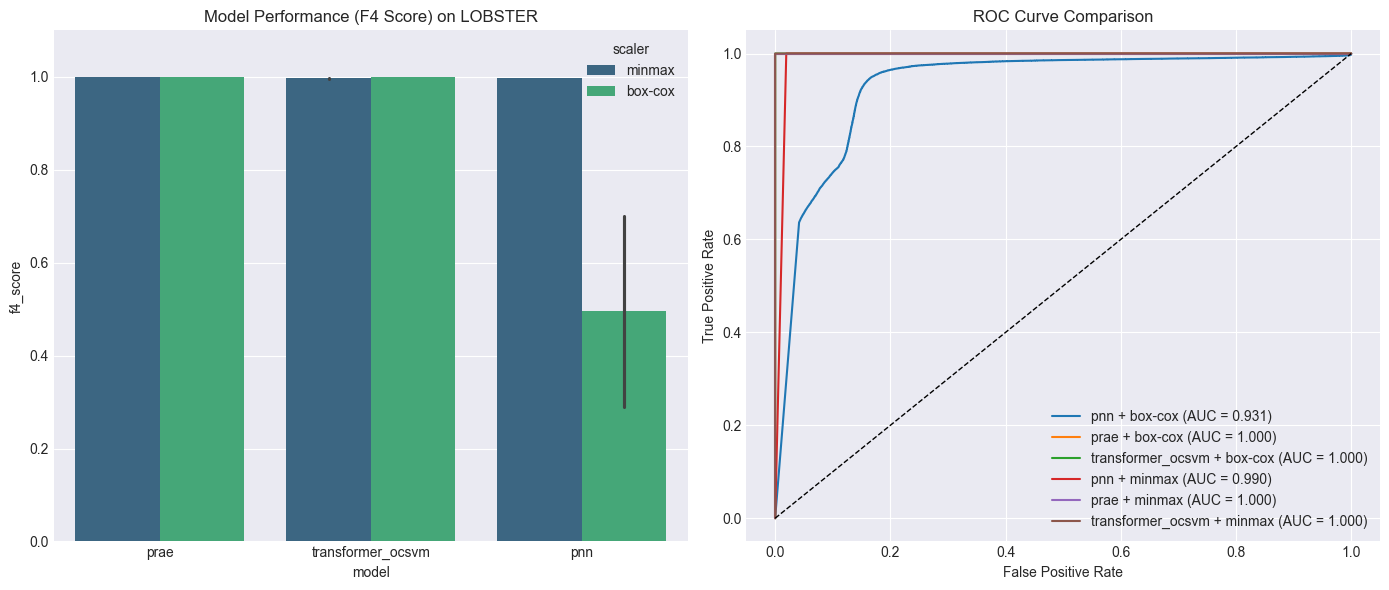

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=results_df, x='model', y='f4_score', hue='scaler', ax=ax[0], palette='viridis')
ax[0].set_title(f'Model Performance (F4 Score) on {dataset_name}')
ax[0].set_ylim(0, 1.1)

for label, (y_test, y_score) in ROC_DATA.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
ax[1].plot([0,1], [0,1], 'k--', lw=1)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve Comparison')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.grid(True)
plt.show()